In [36]:
import os
import pandas as pd
import numpy as np

# === PATHS AND SETUP ===
data_path = "/h/kupfersk/cfpr_2026/data/processed_data_updated/STATSCAN_food_cpi_processed.csv"
forecast_base = "/h/kupfersk/cfpr_2026/generate_forecasts/output/Forecasts"

# Load ground truth CPI data
df = pd.read_csv(data_path, parse_dates=["index"], index_col="index")
food_cat = list(df.columns)
models = sorted(os.listdir(forecast_base))

# Evaluation window
eval_start, eval_end = "2025-01-01", "2025-08-31"

# Storage
category_results = {}       # holds MAPE DataFrame for each category
summary_records = []        # holds (category, model, mape)

# === MAIN LOOP ===
for target_category in food_cat:
    print(f"\nProcessing category: {target_category}")

    # Initialize combined forecast dataframe with ground truth
    forecast_df = pd.DataFrame(df[target_category])
    forecast_df.rename(columns={target_category: "ground_truth"}, inplace=True)

    # Load each model's forecast (q_0.5)
    for model in models:
        forecast_file = os.path.join(
            forecast_base,
            model,
            "random_seed_42",
            "2024-07-01",
            "forecasts",
            f"food_cpi: {target_category}.csv"
        )
        if not os.path.exists(forecast_file):
            continue
        temp = pd.read_csv(forecast_file, parse_dates=["timestamp"]).set_index("timestamp")
        forecast_df[model] = temp["q_0.5"]

    # Slice evaluation window
    eval_df = forecast_df.loc[eval_start:eval_end].copy()

    # Compute MAPE per model
    mape_df = pd.DataFrame(index=eval_df.index)
    for model in [col for col in eval_df.columns if col != "ground_truth"]:
        mape_df[model] = abs((eval_df[model] - eval_df["ground_truth"]) / eval_df["ground_truth"]) * 100

    # Average MAPE per model (for summary)
    mape_summary = mape_df.mean().sort_values(ascending=True)

    # Store detailed category results
    category_results[target_category] = mape_df

    # Append summary rows
    for model, val in mape_summary.items():
        summary_records.append({"category": target_category, "model": model, "MAPE": val})

# === BUILD SUMMARY TABLE ===
summary_df = pd.DataFrame(summary_records)

# Compute overall average MAPE per model (across all categories)
overall_summary = (
    summary_df.groupby("model")["MAPE"]
    .mean()
    .sort_values(ascending=True)
    .reset_index()
)

# Select top 20 best models
top20 = overall_summary.head(20)

# === OUTPUTS ===
print("\nTop 20 Models by Average MAPE (All Categories):")
print(top20.round(2))

# Optional: Save outputs
# overall_summary.to_csv("summary_model_mape.csv", index=False)
# for cat, df_cat in category_results.items():
#     df_cat.to_csv(f"mape_breakdown_{cat.replace('/', '_')}.csv")



Processing category: Food

Processing category: Meat

Processing category: Fish, seafood and other marine products

Processing category: Dairy products and eggs

Processing category: Bakery and cereal products (excluding baby food)

Processing category: Fruit, fruit preparations and nuts

Processing category: Vegetables and vegetable preparations

Processing category: Other food products and non-alcoholic beverages

Processing category: Food purchased from restaurants

Top 20 Models by Average MAPE (All Categories):
                                                model  MAPE
0             claude-3-5-sonnet-20240620_report_False  1.02
1                         gemini-1.5-pro_report_False  1.23
2              claude-3-5-sonnet-20240620_report_True  1.24
3                          gemini-1.5-pro_report_True  1.29
4                               ag_local_AutoETSModel  1.53
5                          ag_global_all_ChronosModel  1.56
6    ag_global_all_SimpleFeedForwardModel_exp1_human_  1.

In [40]:
# === PRINT SMALL SUMMARIES PER CATEGORY ===
print("\n===== Category-Level MAPE Summaries =====")

for cat, df_cat in category_results.items():
    # Compute average MAPE for each model within that category
    cat_mape_summary = df_cat.mean().sort_values(ascending=True)

    # Print top few models for quick inspection
    print(f"\n{cat}")
    print(cat_mape_summary.head(10).round(2))



===== Category-Level MAPE Summaries =====

Food
ag_local_TemporalFusionTransformerModel                    0.48
ag_local_AutoARIMAModel                                    0.74
ag_global_all_SimpleFeedForwardModel_exp5_geopolitical_    0.92
ag_global_all_SimpleFeedForwardModel_exp1_human_           0.93
ag_local_AutoETSModel                                      0.94
ag_global_all_TemporalFusionTransformerModel               0.96
ag_global_all_ChronosModel                                 1.32
ag_global_all_DeepARModel                                  1.51
ag_local_DLinearModel                                      1.53
ag_local_SimpleFeedForwardModel                            1.56
dtype: float64

Meat
ag_local_DeepARModel                                                0.86
ag_global_all_TemporalFusionTransformerModel_exp5_manufacturing_    1.03
ag_global_all_TemporalFusionTransformerModel                        1.04
ag_global_all_TemporalFusionTransformerModel_exp1_human_            1.0

In [41]:
import pickle
import os

# Directory to store evaluation results
save_dir = "./cfpr_evaluation_dicts"
os.makedirs(save_dir, exist_ok=True)

# --- Save from the MAPE notebook ---
with open(os.path.join(save_dir, "./category_results_mape.pkl"), "wb") as f:
    pickle.dump(category_results, f)

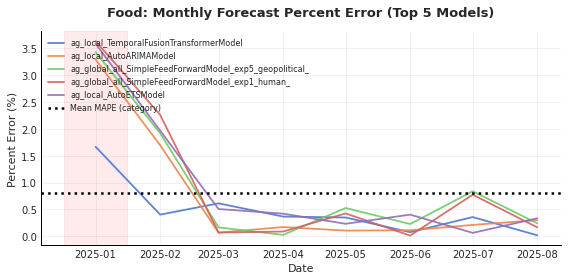

<Figure size 432x288 with 0 Axes>

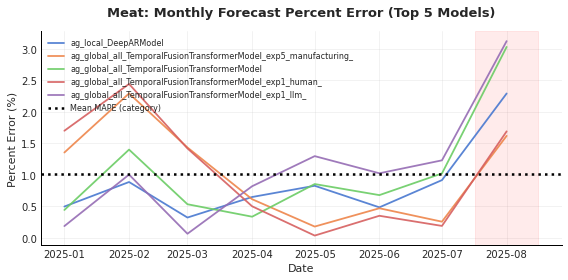

<Figure size 432x288 with 0 Axes>

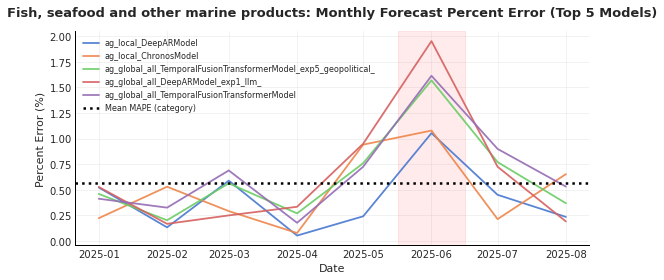

<Figure size 432x288 with 0 Axes>

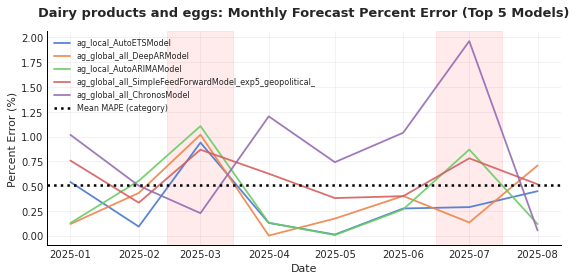

<Figure size 432x288 with 0 Axes>

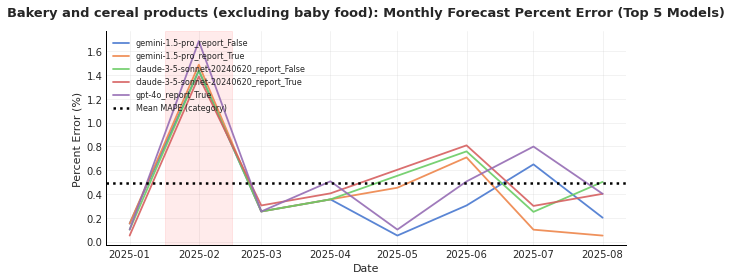

<Figure size 432x288 with 0 Axes>

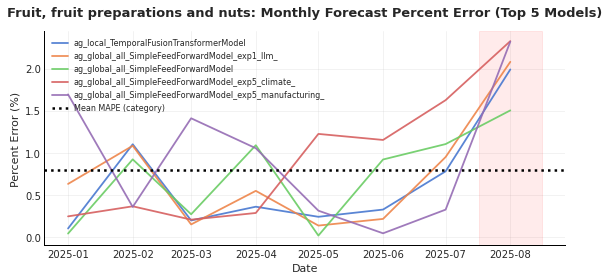

<Figure size 432x288 with 0 Axes>

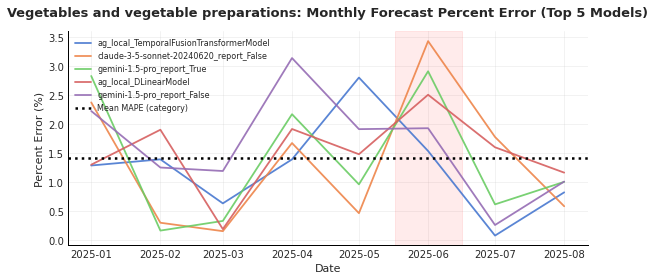

<Figure size 432x288 with 0 Axes>

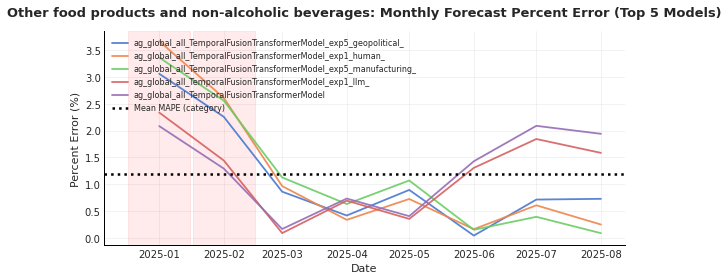

<Figure size 432x288 with 0 Axes>

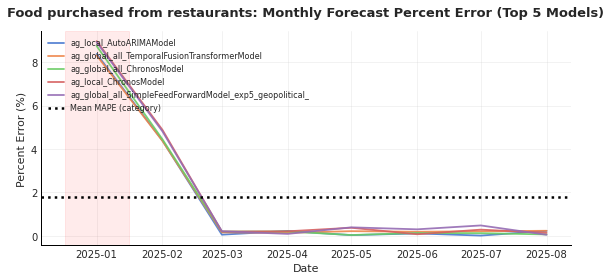

<Figure size 432x288 with 0 Axes>

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import timedelta

# --- Style configuration (to match your ensemble plots) ---
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("muted")
plt.rcParams.update({
    "axes.facecolor": "white",
    "axes.edgecolor": "black",
    "axes.labelsize": 11,
    "axes.titlesize": 13,
    "axes.titleweight": "bold",
    "legend.fontsize": 8,
    "lines.linewidth": 1.8,
    "font.family": "DejaVu Sans"
})

output_dir = "./cfpr_figures_percent_error_dynamic"
os.makedirs(output_dir, exist_ok=True)

# === Generate one figure per food category ===
for category, df_cat in category_results.items():
    # Compute mean MAPE per model and pick top 5
    model_means = df_cat.mean().sort_values().head(5).index
    plot_df = df_cat[model_means]

    # --- Compute category-level statistics ---
    avg_error = plot_df.mean(axis=1)
    mean_mape = avg_error.mean()                     # horizontal reference line
    std_mape = avg_error.std()                       # defines variability threshold
    threshold = mean_mape + std_mape                 # “problematic month” threshold

    # --- Create figure ---
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.set_title(f"{category}: Monthly Forecast Percent Error (Top 5 Models)", pad=15)

    # --- Plot each model ---
    for model in model_means:
        ax.plot(plot_df.index, plot_df[model], label=model, alpha=0.9)

    # --- Add mean MAPE reference line ---
    ax.axhline(mean_mape, color="black", linestyle=":", linewidth=2.5, label="Mean MAPE (category)")

    # --- Highlight problematic months ---
    high_error_mask = avg_error > threshold
    if high_error_mask.any():
        # Shade regions where high error persists (month-to-month)
        for i, (date, is_high) in enumerate(high_error_mask.items()):
            if is_high:
                # Determine span: 1 month wide (approx)
                start = date - timedelta(days=15)
                end = date + timedelta(days=15)
                ax.axvspan(start, end, color="red", alpha=0.08)

    # --- Styling ---
    ax.set_ylabel("Percent Error (%)")
    ax.set_xlabel("Date")
    ax.legend(loc="upper left", frameon=False)
    ax.grid(True, which="both", alpha=0.3)
    sns.despine(ax=ax)
    
    plt.tight_layout()
    plt.show()
    
    # === SAVE & DISPLAY ===
    # Create a clean filename
    safe_name = category.replace("/", "_").replace(",", "").replace(" ", "_")
    save_path = os.path.join(output_dir, f"{safe_name}_percent_error_dynamic.png")

    # Save high-resolution figure
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    
    # Display inline for inspection
    display(plt.gcf())
    plt.close()
    
    
    


In [48]:
# =====================================================================
# === SAVE EVALUATION RESULTS FOR REPORTING AND CROSS-ANALYSIS ===
# =====================================================================

import pickle

save_dir = "./cfpr_evaluation_dicts"
os.makedirs(save_dir, exist_ok=True)

# --- 1️⃣ Save detailed per-category MAPE results (for later analysis)
with open(os.path.join(save_dir, "category_results_mape.pkl"), "wb") as f:
    pickle.dump(category_results, f)

# --- 2️⃣ Save overall average MAPE summary across all models
overall_summary.to_csv(os.path.join(save_dir, "overall_summary_mape.csv"), index=False)

# --- 3️⃣ Save per-category top models (optional, nice for reference)
top_models_per_category = {}
for cat, df_cat in category_results.items():
    top_models = df_cat.mean().sort_values().head(5)
    top_models_per_category[cat] = top_models
top_models_df = (
    pd.DataFrame(top_models_per_category)
    .T
    .sort_index()
)
top_models_df.to_csv(os.path.join(save_dir, "top_models_per_category_mape.csv"))

print("✅ Saved monthly evaluation outputs:")
print(f"• category_results_mape.pkl — detailed MAPE per model, per category")
print(f"• overall_summary_mape.csv — mean MAPE per model (across all categories)")
print(f"• top_models_per_category_mape.csv — top 5 models per food category\n")

# --- Optional confirmation output ---
print("\n===== Top 10 Models Overall (by Average MAPE) =====")
print(overall_summary.head(10).round(3))


✅ Saved monthly evaluation outputs:
• category_results_mape.pkl — detailed MAPE per model, per category
• overall_summary_mape.csv — mean MAPE per model (across all categories)
• top_models_per_category_mape.csv — top 5 models per food category


===== Top 10 Models Overall (by Average MAPE) =====
                                               model   MAPE
0            claude-3-5-sonnet-20240620_report_False  1.018
1                        gemini-1.5-pro_report_False  1.234
2             claude-3-5-sonnet-20240620_report_True  1.237
3                         gemini-1.5-pro_report_True  1.287
4                              ag_local_AutoETSModel  1.529
5                         ag_global_all_ChronosModel  1.562
6   ag_global_all_SimpleFeedForwardModel_exp1_human_  1.739
7  ag_global_all_SimpleFeedForwardModel_exp5_geop...  1.765
8                          ag_global_all_DeepARModel  1.796
9       ag_global_all_TemporalFusionTransformerModel  1.825
